In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import fastai
import pydicom as dicom
from pydicom.filereader import read_dicomdir
from fast_dicom import *

In [3]:
PATH = Path("/home/vhl_ai/Data/MRI/DICOMS")

In [231]:
class ProcessDCM():
    def __init__(self, study_path, new_spacing=np.array([1.,1.,1.])):
        self.new_spacing = new_spacing if new_spacing is not None else None
        self.study_path = study_path
        
    def get_scan(self, slices, is_scan=True):
        if is_scan == True:
            scan, px_spacing = self.proc_scan_files((slices))
        else:
            scan, px_spacing = self.proc_scan_files((slices))
            scan = np.where(scan != np.max(scan), 0, scan)
            scan = np.where(scan == np.max(scan), 1, scan)
            
        #scan will have to be transformed to match the original DICOM    
        return scan, px_spacing
    
    def proc_scan_files(self, slices):
        scan_files = (dicom.read_file(str(i)) for i in slices)
        scan_files = sorted(scan_files, key=lambda x: x.ImagePositionPatient[-1])
        
        #spacing information for conversion
        slice_dist = [abs(float(a.ImagePositionPatient[-1]) - float(b.ImagePositionPatient[-1])) for a,b in zip(scan_files[1:], scan_files[:-1])]
        slice_dist = max_agree(slice_dist)
        px_spacing = list(max_agree([tuple([float(i) for i in f.PixelSpacing]) for f in scan_files]))
        slice_dist, px_spacing
        
        #conversion should always be identity so this will almost always be redundant
        slope, intercept = map(float, [scan_files[0].RescaleSlope, scan_files[0].RescaleIntercept])
        stack = [(i.pixel_array * slope) + intercept for i in scan_files]#[::-1]
        slope, intercept, np.shape(stack)
    
        #remove extraneous slices with wrong dim
        max_dim = max_agree([i.shape for i in stack])
        stack = np.stack([i for i in stack if tuple(i.shape) == max_dim])
        return stack, np.array([slice_dist] + px_spacing[::-1])
    
class GetDCM():
    #Class for setting up mri scan and mask pathways to easily generate data
    def __init__(self, study_path):
        self.study_path = study_path
        
    def get_scan_names(self):
        #get list of all MRI scans in the dataset
        mri_scans = sorted([str(os.path.basename(i)) for i in (self.study_path).ls() if 'HH' in str(i) if '.stl' not in str(i) ])
        return mri_scans
    
    def get_scan_mask(self):
        #retrieve all mri dicom slices from designated scan
        scan_list = self.get_scan_names()
        #this is currently set to pull the second scan for testing functionality
        #Change the way this funciton is handled so that it goes through each scan.
        print(scan_list[-1])
        scan_slices = sorted([i for i in Path(PATH / scan_list[-1] / 'Raw').ls()])
        mask_slices = sorted([i for i in Path(PATH / scan_list[-1] / 'Mask').ls()])
        return scan_slices, mask_slices
        


In [232]:
gdcm = GetDCM(PATH)

In [233]:
foo_scan, foo_mask = gdcm.get_scan_mask()

HH0315


In [234]:
PDCM = ProcessDCM(PATH)

In [235]:
foo_scan, foo_ps = PDCM.get_scan(foo_scan)
foo_mask, foo_mask_ps = PDCM.get_scan(foo_mask, is_scan=False)

In [236]:
np.shape(foo_mask), foo_mask_ps

((120, 512, 512), array([1.216515, 0.390625, 0.390625]))

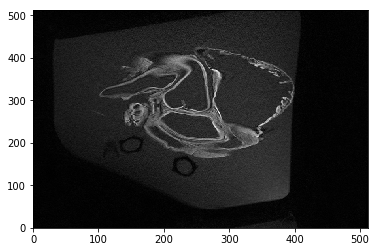

In [237]:
#Check how i need to transform this to match DICOM
plt.set_cmap(plt.gray())
plt.pcolormesh(np.flipud(foo_scan[80, :, :]))

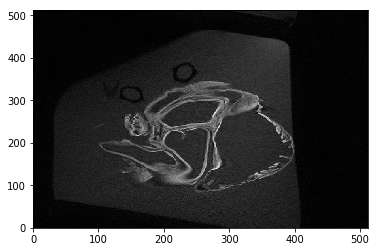

In [238]:
plt.set_cmap(plt.gray())
plt.pcolormesh(foo_scan[80, :, :])

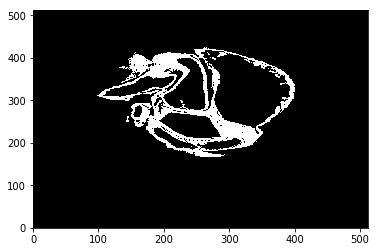

In [239]:
#Check how i need to transform this to match DICOM
plt.set_cmap(plt.gray())
plt.pcolormesh(np.flipud(foo_mask[81, :, :]))

In [240]:
def array_to_png(scan_array, mask_array, save_path):
    for ind in range(len(scan_array)):
        scan_path = Path(save_path / 'image')
        mask_path = Path(save_path / 'mask')
        im = plt.imsave(str(scan_path) + '/' + 'HH0315_0_'+str(ind)+'.png', scan_array[ind,...], format='png')
        msk = plt.imsave(str(mask_path) + '/' + 'HH0315_0_'+str(ind)+'.png', mask_array[ind,...], format='png')
    

In [241]:
array_to_png(foo_scan, foo_mask, save_path = Path(PATH / 'test'))

In [27]:
np.max(foo_scan), np.min (foo_scan)

(2503.0, 0.0)

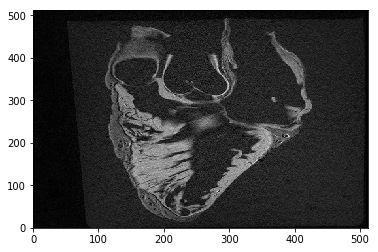

In [33]:
plt.set_cmap(plt.gray())
plt.pcolormesh(np.flip(foo_scan[60, :, :], [0,1]))

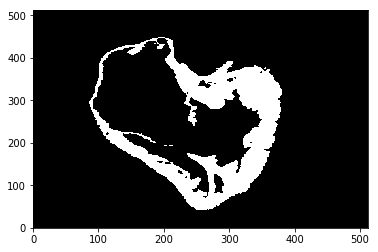

In [17]:
plt.set_cmap(plt.gray())
plt.pcolormesh(np.flipud(foo_mask[73, :, :]))

In [18]:
np.max(foo_mask)

2371.0

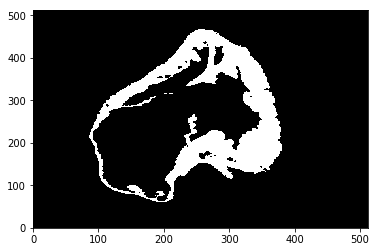

In [13]:
plt.set_cmap(plt.gray())
plt.pcolormesh((foo_mask[73, :, :]))

In [31]:
study_path = PATH
mri_scans = sorted([str(os.path.basename(i)) for i in (study_path).ls() if '.csv' not in str(i) ])
mri_scans

['50mm',
 'HH0059',
 'HH0083',
 'HH0090',
 'HH0094',
 'HH0099',
 'HH0109',
 'HH0110',
 'HH0111',
 'HH0125',
 'HH0131',
 'HH0141',
 'HH0145',
 'HH0156',
 'HH0157',
 'HH0165',
 'HH0168',
 'HH0197',
 'HH0215',
 'HH0221',
 'HH0229',
 'HH0229_Heart.stl',
 'HH0248',
 'HH0251',
 'HH0251_Heart.stl',
 'HH0256',
 'HH0310',
 'HH0311',
 'HH0315']

In [39]:
str(PATH / 'HH0229' / 'Raw')

'/home/vhl_ai/Data/MRI/DICOMS/HH0229/Raw'

In [53]:

foo =dicom.read_file(str(PATH / 'HH0256' / 'Raw' / 'hh256_0000.dcm'))

In [54]:
foo

(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113770.2.1.2662659384.2110896889.3793215996
(0008, 0020) Study Date                          DA: '20140524'
(0008, 0021) Series Date                         DA: '20140524'
(0008, 0022) Acquisition Date                    DA: ''
(0008, 0023) Content Date                        DA: ''
(0008, 0030) Study Time                          TM: '16592.093000'
(0008, 0031) Series Time                         TM: '16592.093000'
(0008, 0032) Acquisition Time                    TM: ''
(0008, 0033) Content Time                        TM: ''
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufacturer                        LO: 'SIEMENS'
(0008, 0080) Institution Name                    LO: 'UMMC,FAIRVIEW^M2'
(00